# Stacking 
而在Stacking里面， 在第一层的模型是通过K-fold Cross validation 形式进行训练和预测。 而Blending的思路相对于把K-fold Cross validation换成Hold-Out。
以下是Stacking 步骤:

<img src=https://pic1.zhimg.com/80/v2-490b92e364070e07a4bd39d514000748_720w.jpg>

(图片来源: https://zhuanlan.zhihu.com/p/91659366)

Stacking 的步骤是：
1. 先把training set 的数据进行K-fold cross validation (sklearn 里面default 2fold) 每个模型都有K个fold的prediction。之后如果有多个不同的模型，就有多个K-fold的prediction。比如说如果我先把训练集分成 5fold,那么就是[X1, X2 ... X5]. 如果我有两个不同的模型, 比如KNN和RandomForest那么对应的prediction分别是[A1, A2...A5], [B1, B2, ... B5]。之后我们可以把对应序号的prediction进行average计算。 比如 [(A1+B1)/2, (A2+B2)/2 ... (A5+B5)/2 ]。
2. 之后把这些模型的输出作为第二层模型的输入。第二层模型一般是logistics regression，这个取决于具体任务
3. 在test set里面， 用第一层的模型对test set的输出进行平均值计算得到第二层模型的测试集的输入，之后第二层模型预测输出。



In [2]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier


iris_data = datasets.load_iris()
X, y = iris_data.data[:, 1:3], iris_data.target

RANDOM_SEED = 2021
# stage 1 models: 
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
# stage 2 model: logistic regression
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
print('3-fold cross validation:\n')
models= zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'NaiveBayes','StackingClassifier']) 
for clf, label in models:
  scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.02) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [NaiveBayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


# 2. Use Grid Search method to optimize stage 1 models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
# stage 2 model: logistic regression
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers= [clf1, clf2, clf3], meta_classifier=lr)
# Note that
# the key should match the string of model name + parameter name

params = {'kneighborsclassifier__n_neighbors': [1, 3, 5],
      'randomforestclassifier__n_estimators': [10, 25, 50,],
      'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5, refit=True)
grid.fit(X, y)
cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.2f %r"
  % (grid.cv_results_[cv_keys[0]][r],
    grid.cv_results_[cv_keys[1]][r] / 2.0,
    grid.cv_results_[cv_keys[2]][r]))
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)


0.933 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 25}
0.947 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 25}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.933 +/- 0.01 {'kneighborsclassifier__n_neighbors': 3, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 3, 'meta_classifier__C': 0.1, 'randomforestclassifier__

In [17]:
# 4.在不同特征子集上运行的分类器的堆叠
##不同的1级分类器可以适合训练数据集中的不同特征子集。以下示例说明了如何使用scikit-learn管道和

from sklearn.datasets import load_iris
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X = iris.data
y = iris.target
# ColumnSelector: an object for selecting specific columns from a dataset
# so when ColumnSelector(cols=(0, 2)), it selects the first and second columns of iris data
pipe_lr1 = make_pipeline(ColumnSelector(cols=(0, 2)), LogisticRegression())
pipe_lr2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)), LogisticRegression())
sclf = StackingCVClassifier(classifiers=[pipe_lr1, pipe_lr2], meta_classifier=LogisticRegression())
_ = sclf.fit(X, y)

In [14]:
ColumnSelector(cols=(0, 2))

ColumnSelector(cols=(0, 2), drop_axis=False)

# Draw ROC Curve

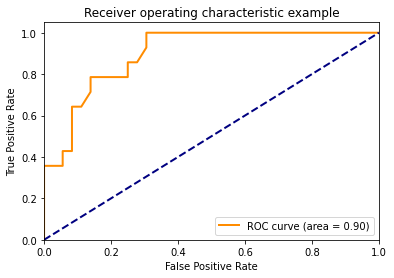

In [86]:
from matplotlib import pyplot as plt

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlxtend.classifier import StackingCVClassifier,StackingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# load data
RANDOM_SEED = 2021
iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target
# Binarize the output / onehot
y = label_binarize(y, classes=[0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=RANDOM_SEED)


# build models
clf1 = LogisticRegression()
clf2 = SVC(random_state=RANDOM_SEED)#RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()


sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)

# In OneVsRestClassifier, for each classifier, the class is fitted against all the other classes. 
clf_ovr = OneVsRestClassifier(clf3)
clf_ovr.fit(X_train, y_train)
y_score = clf_ovr.decision_function(X_test)



fpr = {}
tpr = {}
roc_auc = {}

n_classes = y.shape[1]
# compute ROC curve and AUC for each class

for i in range(n_classes):
  # prediction of the i^th class with binary label, 0 or 1
  fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Conclusion
Blending与Stacking对比:
Blending的优点在于:
+ 比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）
缺点在于：
+ 使用了很少的数据（是划分hold-out作为测试集，并非cv）
+ blender可能会过拟合